# **Аналитика ДТП**
Заказчиком выступает проект [«Карта ДТП»](https://dtp-stat.ru/) — некоммерческий проект, посвященный проблеме дорожно-транспортных происшествий в России.

## Часть 3. Построение дашборда

[Ссылка на дашбород](https://datalens.yandex/s1rbmtass104g)



# Постановка задачи и ход исследования

**Цель:**  

Провести глубокий анализ данных, сформулировать и проверить гипотезы, опираясь на доступные признаки.

**Описание задачи**:
- Провести исследовательский анализ данных о дорожно-транспортных происшествиях (ДТП).
- Сформулировать и проверить гипотезы, основываясь на имеющихся признаках.
- Построить дашборд используя любой удобный инструмент, с учетом того, что дашборд может быть опубликован

**В исследовании:**

В **Части 1** мы провели:
- Загрузку данных из предоставленных файлов
- Чтение и обработку данных в столбцах в форматах json и в списках
- Формирование новых датафреймов, содержащих:
  - данные о транспортных средствах, участвовавших в ДТП
  - о водителях, пассажирах и пешеходах, участвовавших в ДТП
- Обработку данных, изменение типов данных для уменьшения размера занимаемой оперативной памяти
- Формирование трех сводных датасетов, ообъединяющих в себе данные по всем регионам и соджержащие в себе:
  - данные о ДТП
  - данные о транспортных средствах, участвовавших в ДТП
  - о водителях, пассажирах и пешеходах, участвовавших в ДТП  
- Изучение общей информации о датафрейме
- Выгрузку на диск сводных датасетов в виде файлов формата .pickle

В **части 2**  мы провели:
- исследовательский анализ данных
- формирование и проверку гипотез:
  - В большинстве случаев виноваты пьяные водители, нужно усилить контроль
  - Безопасность на дорогах растет для каждого из участников
  - В личном автомобиле ехать безопаснее чем в автобусе
  - Если пешеходы не будут нарушать, то не будут гибнуть
  - Низкая скорость не влияет на тяжесть ДТП

В **части 3** (в этой тетрадке)
- построим дашборд средствами DataLens

In [ ]:
pip install dill --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.9 MB/s eta 0:00:00


In [ ]:
# для извлечения и анализа данных
import pandas as pd
import os
#from pandas_geojson import read_geojson
import re
import requests
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
import warnings
import time # для расчета времени обработки ноутбука
#import logging
import dill as pickle # для сериализации объектов и сохранения данных в формате .pickle
import json
import matplotlib.pyplot as plt

# настройка отображения
pd.options.display.max_columns = 30

Mounted at /content/drive


In [ ]:
# Перейдем в рабочую папку
os.chdir('/content/drive/MyDrive/Мастерская_Аналитика_ДТП')

In [ ]:
# Ознакомимся, какие файлы с данными сохранены на диске
for i in os.listdir():
  if '.pickle' in i:
    if 'data' in i:
      print(i.split('.')[0])

data_base
data_vehicles
data_foot_part


# Создадим функции

In [ ]:
# Для изменения типа данных в столбце
def ch_type(df, col, col_type):
  df[col] = df[col].astype(col_type)
  a1 = sorted(df[col].unique().tolist())
  #display(a1)
  return

In [ ]:
# построим столбчатую диаграмму, чтобы определить значимые количества тех или иных значений
def categ_disp(df, col, title_l):
  plt.figure(figsize=(7,5))
  df[col].value_counts(ascending = True).plot(kind = 'barh', color = 'g')
  plt.title(title_l, color = 'b', fontsize = 20)
  plt.xlabel('Количество случаев', color = 'b', fontsize = 16)
  plt.ylabel(title_l, color = 'b', fontsize = 16)
  plt.xticks(color = 'b', fontsize = 10)
  plt.yticks(color = 'b', fontsize = 10)

  return

# Загрузим и подготовим первый файл - data_base - с основными данными

In [ ]:
# Загрузим первый файл
for i in os.listdir():
    if 'data_base.' in i:
      print(i)
      with open(i, 'rb') as file:
          data_base = pickle.load(file)
      display(data_base.head())

data_base.pickle


,coordinates,id,tags,light,lat,long,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[129.848292, 49.796572]",2525237,[Дорожно-транспортные происшествия],"В темное время суток, освещение отсутствует",49.796572,129.848292,[],Бурейский район,"Прогресс – Бурея – Новобурейск, 24 км",[Пасмурно],Наезд на пешехода,2020-12-10 17:40:00,Легкий,0,1,Амурская область,[Сухое],2,"[Пешеходы, Все участники]"
1,"[129.769821, 49.83001]",2060303,[Дорожно-транспортные происшествия],"В темное время суток, освещение отсутствует",49.830010,129.769821,[],Бурейский район,None,[Ясно],Наезд на препятствие,2018-01-22 00:20:00,С погибшими,1,0,Амурская область,[Со снежным накатом],5,[Все участники]
2,"[129.90612, 49.798774]",2624862,[Дорожно-транспортные происшествия],Светлое время суток,49.798774,129.906120,[АЗС],Бурейский район,Р-297 Амур Чита - Невер - Свободный - Архара -...,[Ясно],Столкновение,2021-09-24 09:20:00,Легкий,0,2,Амурская область,[Сухое],3,[Все участники]
3,"[129.982574, 49.821165]",2624870,[Дорожно-транспортные происшествия],Светлое время суток,49.821165,129.982574,[],Бурейский район,"Гомелевка – Новобурейск – Куликовка, 33 км",[Ясно],Съезд с дороги,2021-09-10 15:00:00,Легкий,0,1,Амурская область,[Сухое],1,[Все участники]
4,"[130.14165, 50.193372]",2536793,[Дорожно-транспортные происшествия],"В темное время суток, освещение отсутствует",50.193372,130.141650,[],Бурейский район,"пгт Талакан, Подъезд к п. Талакан от автомобил...",[Ясно],Опрокидывание,2021-01-16 20:30:00,Легкий,0,1,Амурская область,[Обработанное противогололедными материалами],1,[Все участники]


In [ ]:
# Удалим невостребованные столбцы
data_base = data_base.drop(columns=(['coordinates', 'lat', 'long', 'region', 'address', 'nearby', 'tags', 'weather', 'road_conditions', 'participant_categories']))

In [ ]:
# Для каждого столбца выведем на экран уникальные значения и их количество
for i in data_base.columns:
  print(f'\033[1m\033[95mСтолбец {i} \033[0m\n Количество значений {data_base[i].nunique()}  \n {data_base[i].unique()}')

Столбец id 
 Количество значений 1411646  
 [2525237 2060303 2624862 ... 1867222 1874000 1867695]
Столбец light 
 Количество значений 6  
 ['В темное время суток, освещение отсутствует', 'Светлое время суток', 'В темное время суток, освещение включено', 'Сумерки', 'В темное время суток, освещение не включено', 'Не установлено']
Categories (6, object): ['В темное время суток, освещение включено', 'В темное время суток, освещение не включено',
                         'В темное время суток, освещение отсутствует', 'Не установлено', 'Светлое время суток', 'Сумерки']
Столбец category 
 Количество значений 18  
 ['Наезд на пешехода', 'Наезд на препятствие', 'Столкновение', 'Съезд с дороги', 'Опрокидывание', ..., 'Наезд на животное', 'Наезд на лицо, не являющееся участником дорож..., 'Наезд на внезапно возникшее препятствие', 'Наезд на гужевой транспорт', 'Возгорание вследствие технической неисправнос...]
Length: 18
Categories (18, object): ['Возгорание вследствие технической неисправнос...,


- В столбце light присутствует 6 уникальных значений. Систематизируем их и при неоьходимости  снизим их количество.
- В столбце category присутствует 18 уникальных значений. Систематизируем их и снизим их количество.   
- В столбце severity - категории "Легкий" и "Тяжелый" не несут для нас никакой информации, информацию о тяжести мя полуим из столбцов injured_count и dead_count. Систематизируем их и снизим их количество.   

---



- В столбце category присутствует 18 уникальных значений. Систематизируем их и снизим их количество.   
Выведем на экран в алфавитном порядке.   
После чего построим столбчатую диаграмму, чтобы определить значимые количества тех или иных значений в категориях

In [ ]:
sorted(data_base.category.unique().tolist())

['Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении.',
 'Иной вид ДТП',
 'Наезд на велосипедиста',
 'Наезд на внезапно возникшее препятствие',
 'Наезд на гужевой транспорт',
 'Наезд на животное',
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность',
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы',
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ',
 'Наезд на пешехода',
 'Наезд на препятствие',
 'Наезд на стоящее ТС',
 'Опрокидывание',
 'Отбрасывание предмета',
 'Падение груза',
 'Падение пассажира',
 'Столкновение',
 'Съезд с дороги']

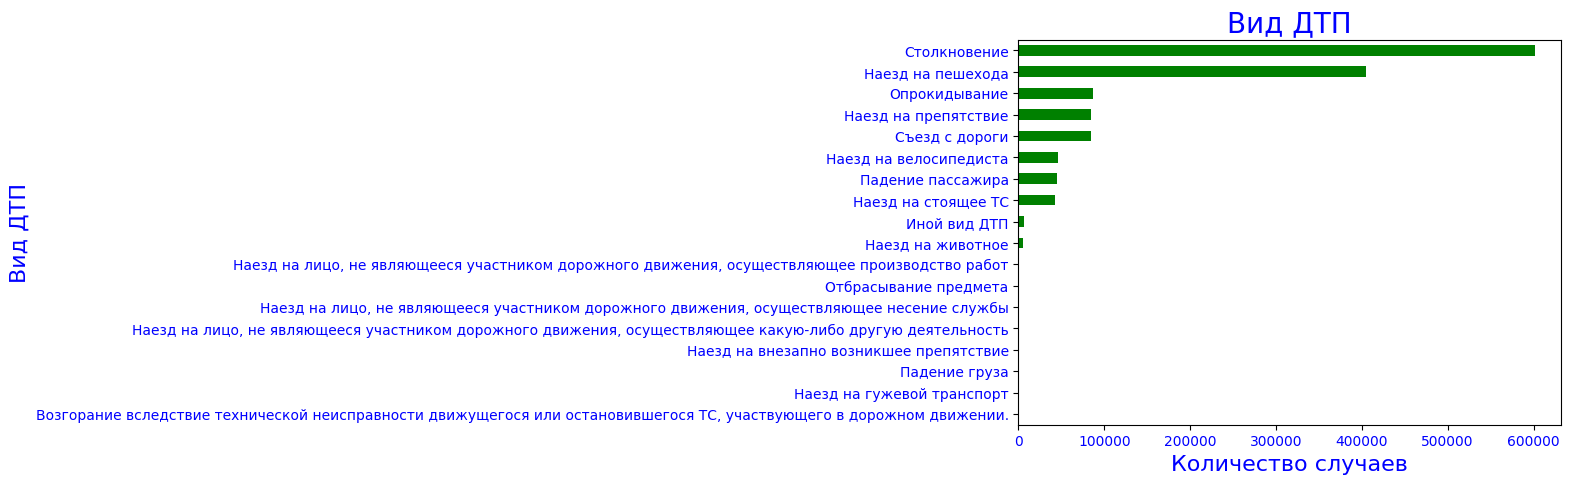

In [ ]:
categ_disp(data_base, 'category', 'Вид ДТП')

Произведем категоризацию категорий происшествий.
Распределим на:
- Столкновения - сюда отнесем только столкновения
- Наезды - сюда отнесем все наезды
- Опрокидывание - только опрокидывания
- Съезд с дороги - только съезды с дороги
- Падение пассажира - только падение пассажира
- Падение груза - сюда отнесем падение груза и отбрасывание
- Иной вид ДТП - отнесем инлй вид ДТП и Возгорание


In [ ]:
# создадим переменную a1 - она не займет много места, но с ней будет удобнее написать код
a1 = sorted(data_base.category.unique().tolist())
a1

['Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении.',
 'Иной вид ДТП',
 'Наезд на велосипедиста',
 'Наезд на внезапно возникшее препятствие',
 'Наезд на гужевой транспорт',
 'Наезд на животное',
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность',
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы',
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ',
 'Наезд на пешехода',
 'Наезд на препятствие',
 'Наезд на стоящее ТС',
 'Опрокидывание',
 'Отбрасывание предмета',
 'Падение груза',
 'Падение пассажира',
 'Столкновение',
 'Съезд с дороги']

In [ ]:
# Для корректности дальнейшей визуализации вернем ненадолго значениям в столбце light тип данных object
data_base['category'] = data_base['category'].astype('object')

In [ ]:
# Произведем замены для происшествий, связанных с падением
for i in range(len(a1)):
  if i in range(2,12):
    data_base.loc[data_base.category == a1[i], 'category'] = 'Наезд'
  elif i == 0:
    data_base.loc[data_base.category == a1[i], 'category'] = 'Иной вид ДТП'
  elif i == 13:
    data_base.loc[data_base.category == a1[i], 'category'] = 'Падение груза'
  else:
    data_base.loc[data_base.category == a1[i], 'category'] = data_base.category

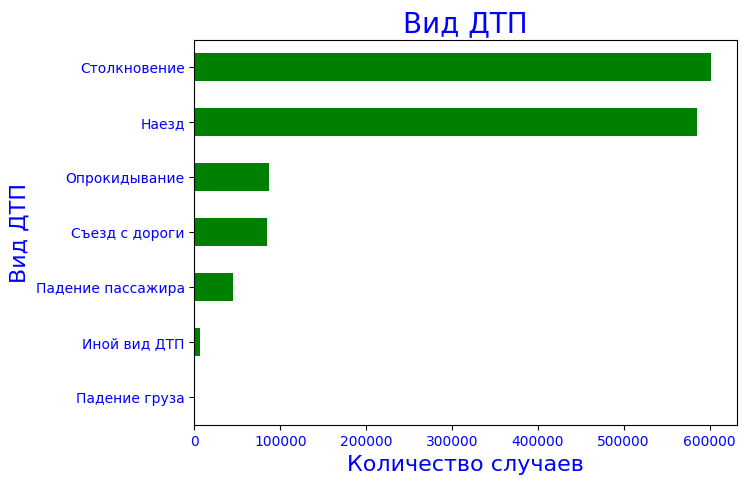

In [ ]:
categ_disp(data_base, 'category', 'Вид ДТП')

In [ ]:
data_base.head()

,id,light,category,datetime,severity,dead_count,injured_count,parent_region,participants_count
0,2525237,"В темное время суток, освещение отсутствует",Наезд,2020-12-10 17:40:00,Легкий,0,1,Амурская область,2
1,2060303,"В темное время суток, освещение отсутствует",Наезд,2018-01-22 00:20:00,С погибшими,1,0,Амурская область,5
2,2624862,Светлое время суток,Столкновение,2021-09-24 09:20:00,Легкий,0,2,Амурская область,3
3,2624870,Светлое время суток,Съезд с дороги,2021-09-10 15:00:00,Легкий,0,1,Амурская область,1
4,2536793,"В темное время суток, освещение отсутствует",Опрокидывание,2021-01-16 20:30:00,Легкий,0,1,Амурская область,1


- В столбце light присутствует 6 уникальных значений.
Выведем на экран в алфавитном порядке.   
После чего построим столбчатую диаграмму, чтобы определить значимые количества тех или иных значений в категориях

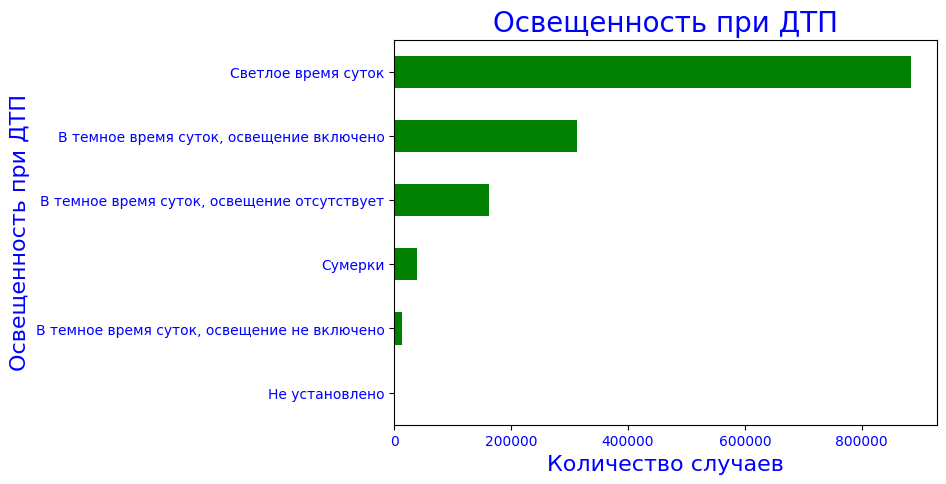

In [ ]:
categ_disp(data_base, 'light', 'Освещенность при ДТП')

In [ ]:
# создадим переменную a2 - она не займет много места, но с ней будет удобнее написать код
a2 = sorted(data_base.light.unique().tolist())
a2

['В темное время суток, освещение включено',
 'В темное время суток, освещение не включено',
 'В темное время суток, освещение отсутствует',
 'Не установлено',
 'Светлое время суток',
 'Сумерки']

In [ ]:
# Объединим значений для не включенного и отссутствующего освещения
data_base.loc[data_base.light == a2[1], 'light'] = a2[2]

In [ ]:
# Для корректности дальнейшей визуализации вернем ненадолго значениям в столбце light тип данных object
data_base['light'] = data_base['light'].astype('object')

In [ ]:
data_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411646 entries, 0 to 1411645
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1411646 non-null  int32         
 1   light               1411646 non-null  object        
 2   category            1411646 non-null  object        
 3   datetime            1411646 non-null  datetime64[ns]
 4   severity            1411646 non-null  category      
 5   dead_count          1411646 non-null  int8          
 6   injured_count       1411646 non-null  int8          
 7   parent_region       1411646 non-null  category      
 8   participants_count  1411646 non-null  int8          
dtypes: category(2), datetime64[ns](1), int32(1), int8(3), object(2)
memory usage: 44.4+ MB


In [ ]:
data_base['light'].unique()

array(['В темное время суток, освещение отсутствует',
       'Светлое время суток', 'В темное время суток, освещение включено',
       'Сумерки', 'Не установлено'], dtype=object)

- В столбце severity - категории "Легкий" и "Тяжелый" не несут для нас никакой информации, информацию о тяжести мя полуим из столбцов injured_count и dead_count. Систематизируем их и снизим их количество.  

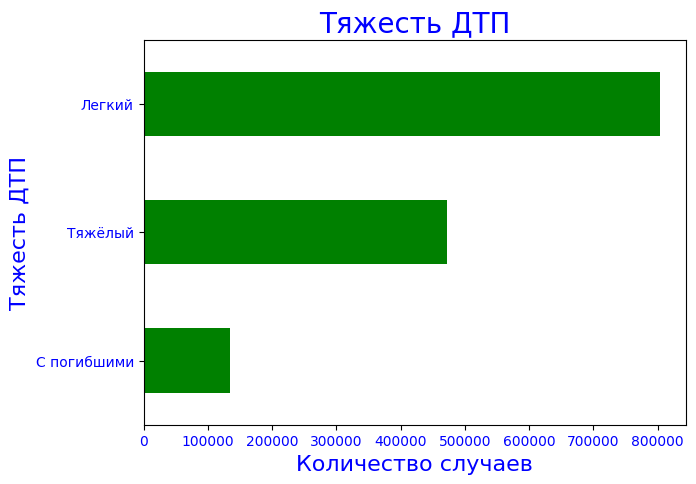

In [ ]:
categ_disp(data_base, 'severity', 'Тяжесть ДТП')

In [ ]:
# создадим переменную a3 - она не займет много места, но с ней будет удобнее написать код
a3 = sorted(data_base.severity.unique().tolist())
a3

['Легкий', 'С погибшими', 'Тяжёлый']

In [ ]:
# Для корректности дальнейшей визуализации вернем ненадолго значениям в столбце light тип данных object
data_base['severity'] = data_base['severity'].astype('object')

In [ ]:
# Объединим значения для леггих и тяжелых случаев
data_base.loc[(data_base.severity == a3[0]) | (data_base.severity == a3[2]) , 'severity'] = "Без погибших"

In [ ]:
# Столбцам  category, light, severity вернем тип переменной category
for i in ['category', 'light', 'severity']:
  data_base[i] = data_base[i].astype('category')

In [ ]:
data_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411646 entries, 0 to 1411645
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1411646 non-null  int32         
 1   light               1411646 non-null  category      
 2   category            1411646 non-null  category      
 3   datetime            1411646 non-null  datetime64[ns]
 4   severity            1411646 non-null  category      
 5   dead_count          1411646 non-null  int8          
 6   injured_count       1411646 non-null  int8          
 7   parent_region       1411646 non-null  category      
 8   participants_count  1411646 non-null  int8          
dtypes: category(4), datetime64[ns](1), int32(1), int8(3)
memory usage: 25.6 MB


Сохраним датафрейм на диск в формате .csv.   
**Поскольку выгружаемый файл csv займет на ддиске более 200 МВ, нам придется разделить его на две части и вырузить по частям**
После чего обратимся к DataLens  и построим дашборд со следующими чартами:
- количество ДТП:
 - по годам и по месяцам - как визуализация гипотезы "Безопасность на дорогах растет для каждого из участников"
 - по регионам
 - по времени суток
 - по категории - наезд, столкновение  и прочее
 - количество погибших
 - количество пострадавших
 - количество участников ДТП
 - доля погибщих к количеству участников ДТП
 - доля пострадавших к количеству участников ДТП

Установим фильтры:
- количество погибших
- количество пострадавших
- год
- месяц
- время суток
- регион
- Днем/ночью/ освещение


- пьяный/трезвый
- умерли в течение какого периода после ДТП
- С пешеходами и без пешеходов
- В зависимости от цвета ТС
- В зависимости от местонахождения – nearby или в/за городом
- В зависимости от состояния дороги road_conditions
- От вида ТС

**Но нам нужны удельные показатели**




In [ ]:
# Поскольку выгружаемый файл csv займет на ддиске более 200 МВ, нам придется разделить его на две части и вырузить по частям
# Выведем столбцы
data_base.columns

Index(['id', 'light', 'category', 'datetime', 'severity', 'dead_count',
       'injured_count', 'parent_region', 'participants_count'],
      dtype='object')

In [ ]:
'''# Разделим  data_base на две части
data_base_part_1 = data_base[data_base.columns[:4]]
data_base_part_2 = data_base[['id'] + data_base.columns[4:].tolist() ]
# print(f'data_base_part_1\n {data_base_part_1.head(2)} \n\n data_base_part_2 \n{data_base_part_2.head(2)}')
'''

"# Разделим  data_base на две части\ndata_base_part_1 = data_base[data_base.columns[:4]]\ndata_base_part_2 = data_base[['id'] + data_base.columns[4:].tolist() ]\n# print(f'data_base_part_1\n {data_base_part_1.head(2)} \n\n data_base_part_2 \n{data_base_part_2.head(2)}')\n"

In [ ]:
'''# Сохраним обе части на диск в формате .csv
data_base_part_1.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_base_part_1.csv', sep=',')
data_base_part_2.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_base_part_2.csv', sep=',')
'''

"# Сохраним обе части на диск в формате .csv\ndata_base_part_1.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_base_part_1.csv', sep=',')\ndata_base_part_2.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_base_part_2.csv', sep=',')\n"

In [ ]:
# Разделим  data_base на четыре части
#data_base_part_11 = data_base[data_base.columns[:3]]
data_base_part_12 = data_base[['id'] + data_base.columns[3:5].tolist() ]
data_base_part_13 = data_base[['id'] + data_base.columns[5:7].tolist() ]
data_base_part_14 = data_base[['id'] + data_base.columns[7:].tolist() ]
# print(f'data_base_part_1\n {data_base_part_1.head(2)} \n\n data_base_part_2 \n{data_base_part_2.head(2)}')

In [ ]:
'''# Сохраним обе части на диск в формате .csv
data_base_part_11.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_base_part_11.csv', sep=',')
data_base_part_12.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_base_part_12.csv', sep=',')
data_base_part_13.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_base_part_13.csv', sep=',')
data_base_part_14.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_base_part_14.csv', sep=',')
'''

"# Сохраним обе части на диск в формате .csv\ndata_base_part_11.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_base_part_11.csv', sep=',')\ndata_base_part_12.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_base_part_12.csv', sep=',')\ndata_base_part_13.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_base_part_13.csv', sep=',')\ndata_base_part_14.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_base_part_14.csv', sep=',')\n"

In [ ]:
del data_base

# Загрузим и подготовим второй файл - data_vehicles - с основными данными

In [ ]:
# Загрузим первый файл
for i in os.listdir():
    if 'data_vehicles.pickle' in i:
      print(i)
      with open(i, 'rb') as file:
          data_vehicles = pickle.load(file)
      display(data_vehicles.head())

data_vehicles.pickle


,id,year,brand,color,model,category
0,2525237,2018,ПАЗ,Белый,32054,Прочие одноярусные
1,2060303,2003,TOYOTA,Черный,Crown,"С-класс (малый средний, компактный) до 4,3 м"
2,2624862,2003,FREIGHTLINER,Белый,Century Class S/T,Седельные тягачи
3,2624862,2014,MITSUBISHI,Белый,Прочие модели Mitsubishi,Бортовые грузовые автомобили
4,2624870,2011,TOYOTA,Серый,Corolla,"D-класс (средний) до 4,6 м"


In [ ]:
# Удалим невостребованные столбцы
#data_vehicles = data_vehicles.drop(columns=(['coordinates', 'lat', 'long', 'region', 'address', 'nearby', 'tags', 'weather', 'road_conditions', 'participant_categories']))

In [ ]:
# Для каждого столбца выведем на экран уникальные значения и их количество
for i in data_vehicles.columns:
  print(f'\033[1m\033[95mСтолбец {i} \033[0m\n Количество значений {data_vehicles[i].nunique()}  \n {data_vehicles[i].unique()}')

Столбец id 
 Количество значений 1411646  
 [2525237 2060303 2624862 ... 1867222 1874000 1867695]
Столбец year 
 Количество значений 94  
 [2018 2003 2014 2011 2010 2013 1980 1993 1988 2017 1999 2005 1985 1982
 1987 2000 2012 1996 1998 1997 1990 'Не заполнено' 2020 1986 1984 2016
 2021 2007 2002 1983 2001 2008 2004 2006 2019 1975 1994 2009 1992 1991
 2022 1989 1974 2015 1995 1977 2023 1981 1979 1978 1972 1969 1967 1968
 1959 1976 1963 1970 1973 1962 1971 1964 1960 1958 1965 1951 1948 1956
 1950 1966 1955 1961 1957 1923 2024 1954 1952 1910 1911 1953 1909 1919
 1949 1928 1920 1941 1937 1918 1936 1907 1942 1946 1934 1901]
Столбец brand 
 Количество значений 369  
 ['ПАЗ', 'TOYOTA', 'FREIGHTLINER', 'MITSUBISHI', 'NISSAN', ..., 'CONFEDERATE', 'MORGAN', 'MC LAREN', 'AUTOBIANCHI', 'TALBOT']
Length: 369
Categories (369, object): ['ABM', 'AC', 'ACURA', 'ADMIRAL', ..., 'СимАЗ', 'ТАГАЗ (TAGAZ)', 'УАЗ',
                           'УРАЛ']
Столбец color 
 Количество значений 13  
 ['Белый', 'Черный'


- В столбце brand  и столбце model присутствуют 369 и 2780 уникальных значений. Нет возможности их унифицировать. Оставим их без изменений.
- В столбце category присутствует 102 уникальных значения. Систематизируем их и снизим их количество.   
  

---



- В столбце category присутствуют 102 уникальных значения. Систематизируем их и снизим их количество.   
Выведем на экран в алфавитном порядке.   
После чего построим столбчатую диаграмму, чтобы определить значимые количества тех или иных значений в категориях

In [ ]:
sorted(data_vehicles.category.unique().tolist())

['D-класс (средний) до 4,6 м',
 'S-класс (высший, представительский класс) более 4,9 м',
 'А-класс (особо малый) до 3,5 м',
 'Автобетононасосы',
 'Автобетоносмесители',
 'Автобусы (без типа)',
 'Автогрейдеры',
 'Автогудронаторы',
 'Автодома',
 'Автокраны и транспортные средства, оснащенные кранами-манипуляторами',
 'Автолесовозы',
 'Автомобили скорой медицинской помощи',
 'Автоцементовозы',
 'Автоэвакуаторы',
 'Боевая техника',
 'Бортовые',
 'Бортовые грузовые автомобили',
 'Бульдозеры',
 'В-класс (малый) до 3,9 м',
 'Велосипеды',
 'Грузовые автомобили (без типа)',
 'Гужевой транспорт',
 'Двухэтажные',
 'Двухярусные',
 'Е-класс (высший средний, бизнес-класс) до 4,9 м',
 'Иные ТС',
 'Иные дорожно-строительные и дорожно-эксплуатационные машины и механизмы',
 'Иные мототранспортные средства',
 'Карьерные самосвалы',
 'Квадрициклы',
 'Квадроциклы',
 'Легковые автомобили (без типа)',
 'Медицинские комплексы на шасси транспортных средств',
 'Минивэны и универсалы повышенной вместимости',
 'М

Ранее, в части 2 исследования, мы уже классифицировали легковые автомобили и автобусы:
К личным автомобилям отнесем записи в столбце `category`, содержащие слова:
- "класс", в том числе 'S-класс', несмотря на то, что эти автомашины далеко не всегда относятся к категории личных автомобилей. Заметим, что корректность отнесения конкретных марок автомобилей к тому или иному классу требует корректировки, если будет задача, связанная с , скажем, безопасностью автомобилей того или иного класса.
- ‘легковы’ – сюда попадут 'Прочие легковые автомобили' и 'Легковые автомобили (без типа)' и 'Прицепы к легковым автомобилям'
- 'спортивные'
- 'минивэны'
- 'автодома'

К автобусам отнесем записи в столбце `category`, содержащие слова (части слов):
- 'бусы' – сюда попадут Школьные автобусы, Автобусы (без типа), троллейбусы, Электробусы
- ‘одно’ – сюда попадут одноярусные и одноэтажные автобусы
- ‘двух’ – сюда попадут двухярусные и двухэтажные автобусы
- 'трамваи'

Сейчас создадим новые категории.

К мототранспорту отнесем записи, в столбце `category`, содержащие слова (части слов):
- мото
- квадр
- мопед
- снего

In [ ]:
# понизим регистр
data_vehicles.category = data_vehicles.category.str.lower()

Произведем категоризацию категорий транспорта.
Распределим на автомобли, автобусы, мототранспорт и прочее

In [ ]:
# Создадим список категорий, которые мы отнесем к легковым автомобилям
list_mobile = []
list_bus = []
list_moto = []
list_truck = []
list_bike = []
for i in data_vehicles.category.unique().tolist():
  for j in ["класс", 'легковы', 'спортивные', 'минивэны', 'автодома']:
      if j in i:
          list_mobile.append(i)
  for k in ["бусы", 'одно', 'двух', 'трамваи']:
      if k in i:
          list_bus.append(i)
  for l in ["мото", 'квадр', 'трицик', 'мопед', 'снегох']:
      if l in i:
          list_moto.append(i)
  for m in ['тягач', 'фургон', 'грузовые', 'самосвал', 'бортов',
            'рефриже', 'цистерны', 'длинномер','бетон','прицеп', 'кран', 'шасси']:
      if m in i:
          list_truck.append(i)
  for n in ["велос"]:
      if n in i:
          list_bike.append(i)
print(list_mobile)
print(list_bus)
print(list_moto)

['с-класс (малый средний, компактный) до 4,3 м', 'd-класс (средний) до 4,6 м', 'в-класс (малый) до 3,9 м', 'прочие легковые автомобили', 'е-класс (высший средний, бизнес-класс) до 4,9 м', 'спортивные (гоночные)', 'минивэны и универсалы повышенной вместимости', 'а-класс (особо малый) до 3,5 м', 'легковые автомобили (без типа)', 's-класс (высший, представительский класс) более 4,9 м', 'автодома', 'прицепы к легковым автомобилям']
['прочие одноярусные', 'одноэтажные длиной от 8 до 12 м', 'одноэтажные длиной не более 5 м', 'школьные автобусы', 'одноэтажные длиной от 5 до 8 м', 'автобусы (без типа)', 'прочие одноэтажные', 'одноэтажные, сочлененные длиной более 12 м', 'трамваи', 'троллейбусы', 'двухярусные', 'двухэтажные', 'электробусы']
['мотоциклы', 'мопеды с двигателем внутреннего сгорания менее 50 см. куб.', 'мопеды с двигателем внутреннего сгорания более 50 см. куб.', 'трициклы', 'квадроциклы', 'мотороллеры', 'иные мототранспортные средства', 'снегоходы', 'квадрициклы', 'мототранспорт (

In [ ]:
# создадим словарь для категоризации категорий транспортных средств
dict_type = {}
for i in list_mobile:
  dict_type[i] = 'mobile'
for j in list_bus:
  dict_type[j] = 'bus'
for k in list_moto:
  dict_type[k] = 'moto'
for l in list_truck:
  dict_type[l] = 'truck'
for m in list_bike:
  dict_type[m] = 'bike'

In [ ]:
dict_type

{'с-класс (малый средний, компактный) до 4,3 м': 'mobile',
 'd-класс (средний) до 4,6 м': 'mobile',
 'в-класс (малый) до 3,9 м': 'mobile',
 'прочие легковые автомобили': 'mobile',
 'е-класс (высший средний, бизнес-класс) до 4,9 м': 'mobile',
 'спортивные (гоночные)': 'mobile',
 'минивэны и универсалы повышенной вместимости': 'mobile',
 'а-класс (особо малый) до 3,5 м': 'mobile',
 'легковые автомобили (без типа)': 'mobile',
 's-класс (высший, представительский класс) более 4,9 м': 'mobile',
 'автодома': 'mobile',
 'прицепы к легковым автомобилям': 'truck',
 'прочие одноярусные': 'bus',
 'одноэтажные длиной от 8 до 12 м': 'bus',
 'одноэтажные длиной не более 5 м': 'bus',
 'школьные автобусы': 'bus',
 'одноэтажные длиной от 5 до 8 м': 'bus',
 'автобусы (без типа)': 'bus',
 'прочие одноэтажные': 'bus',
 'одноэтажные, сочлененные длиной более 12 м': 'bus',
 'трамваи': 'bus',
 'троллейбусы': 'bus',
 'двухярусные': 'bus',
 'двухэтажные': 'bus',
 'электробусы': 'bus',
 'мотоциклы': 'moto',
 'м

In [ ]:
# Произведем категоризацию и в столбец type_vehicle укажем тип транспортного средства
data_vehicles['type_vehicle'] = data_vehicles['category'].map(dict_type)
# Поскольку нас интересуют только автомобили и автобусы, удалим пустые записи
#mobile_bus = mobile_bus[mobile_bus.type_vehicle.notna()]

In [ ]:
#data_vehicles['category'] = data_vehicles['category'].fillna("another")
data_vehicles['type_vehicle'] = data_vehicles['type_vehicle'].fillna("another")

In [ ]:
#data_vehicles.loc[data_vehicles.type_vehicle.isna(), 'type_vehicle'] = \
#    data_vehicles.loc[data_vehicles.type_vehicle.isna(), 'category']

In [ ]:
data_vehicles['type_vehicle'].unique()

array(['bus', 'mobile', 'truck', 'moto', 'bike', 'another'], dtype=object)

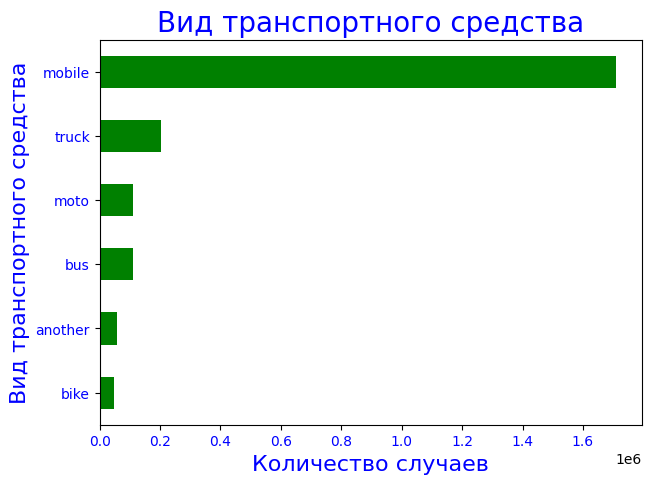

In [ ]:
# построим столбчатую диаграмму, чтобы определить значимые количества тех или иных значений
categ_disp(data_vehicles, 'type_vehicle', 'Вид транспортного средства')

Произведем категоризацию категорий происшествий.
Распределим на:
- Столкновения - сюда отнесем только столкновения
- Наезды - сюда отнесем все наезды
- Опрокидывание - только опрокидывания
- Съезд с дороги - только съезды с дороги
- Падение пассажира - только падение пассажира
- Падение груза - сюда отнесем падение груза и отбрасывание
- Иной вид ДТП - отнесем инлй вид ДТП и Возгорание


In [ ]:
# заменим значения в столбце category на значения из type_vehicle
# удамил столбец type_vehicle
data_vehicles.category = data_vehicles.type_vehicle
data_vehicles = data_vehicles.drop(columns='type_vehicle')

In [ ]:
# создадим переменную a1 - она не займет много места, но с ней будет удобнее написать код
a2 = sorted(data_vehicles.category.unique().tolist())
a2

['another', 'bike', 'bus', 'mobile', 'moto', 'truck']

In [ ]:
# Присвоим значениям в столбце category тип данных category
data_vehicles['category'] = data_vehicles['category'].astype('category')

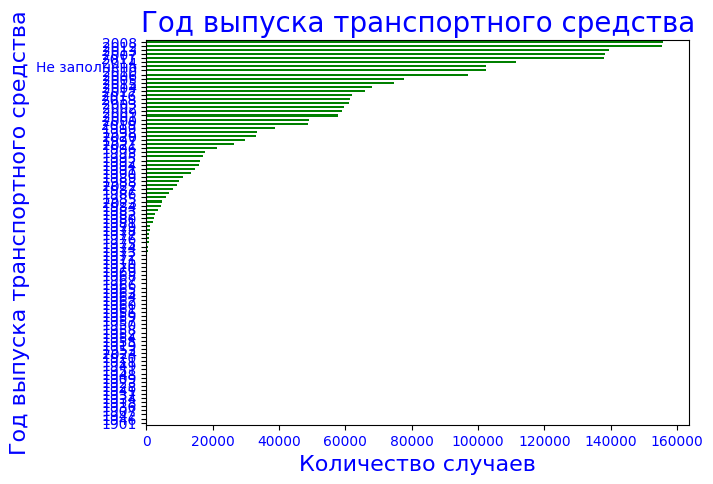

In [ ]:
# построим столбчатую диаграмму, чтобы определить значимые количества тех или иных значений
categ_disp(data_vehicles, 'year', 'Год выпуска транспортного средства')

In [ ]:
data_vehicles.head()

,id,year,brand,color,model,category
0,2525237,2018,ПАЗ,Белый,32054,bus
1,2060303,2003,TOYOTA,Черный,Crown,mobile
2,2624862,2003,FREIGHTLINER,Белый,Century Class S/T,truck
3,2624862,2014,MITSUBISHI,Белый,Прочие модели Mitsubishi,truck
4,2624870,2011,TOYOTA,Серый,Corolla,mobile


In [ ]:
data_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240533 entries, 0 to 2240532
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   id        int32   
 1   year      object  
 2   brand     category
 3   color     category
 4   model     category
 5   category  category
dtypes: category(4), int32(1), object(1)
memory usage: 38.5+ MB


Сохраним датафрейм на диск в формате .csv.   
После чего обратимся к DataLens  и построим дашборд со следующими чартами:
- количество ДТП:
 - по годам выпуска автомобилей
 - по категориям
 - по цвету автомобиля

 Соединим с файлом data_foot_part и рассмотрим указанные выше категории в разрезе
 - количества ДТП
 - участников ДТП
 - раненых и травмированных
 - погибших
 - доля погибщих к количеству участников ДТП
 - доля пострадавших к количеству участников ДТП



  Соединим с файлом data_base и рассмотрим указанные выше категории в разрезе
 - категории освещенности
 - погоды
 - категории ДТП - столкновение, наезд



Установим фильтры:
- количество погибших
- количество пострадавших
- год
- месяц
- время суток
- регион
- Днем/ночью/ освещение


- пьяный/трезвый
- умерли в течение какого периода после ДТП
- С пешеходами и без пешеходов
- В зависимости от цвета ТС
- В зависимости от местонахождения – nearby или в/за городом
- В зависимости от состояния дороги road_conditions
- От вида ТС

**Но нам нужны удельные показатели**




In [ ]:
# Поскольку выгружаемый файл csv займет на ддиске более 200 МВ, нам придется разделить его на две части и вырузить по частям
# Выведем столбцы
data_vehicles.columns

Index(['id', 'year', 'brand', 'color', 'model', 'category'], dtype='object')

In [ ]:
# Сохраним обе части на диск в формате .csv
data_vehicles.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_vehicles.csv', sep=',')

In [ ]:
'''# Разделим  data_vehicles на две части
data_vehicles_part_1 = data_vehicles[data_vehicles.columns[:4]]
data_vehicles_part_2 = data_vehicles[['id'] + data_vehicles.columns[4:].tolist() ]
print(f'data_vehicles_part_1\n {data_vehicles_part_1.head(2)} \n\n data_vehicles_part_2 \n{data_vehicles_part_2.head(2)}')
'''

"# Разделим  data_vehicles на две части\ndata_vehicles_part_1 = data_vehicles[data_vehicles.columns[:4]]\ndata_vehicles_part_2 = data_vehicles[['id'] + data_vehicles.columns[4:].tolist() ]\nprint(f'data_vehicles_part_1\n {data_vehicles_part_1.head(2)} \n\n data_vehicles_part_2 \n{data_vehicles_part_2.head(2)}')\n"

In [ ]:
'''# Сохраним обе части на диск в формате .csv
data_vehicles_part_1.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_vehicles_part_1.csv', sep=',')
data_vehicles_part_2.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_vehicles_part_2.csv', sep=',')
'''

"# Сохраним обе части на диск в формате .csv\ndata_vehicles_part_1.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_vehicles_part_1.csv', sep=',')\ndata_vehicles_part_2.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_vehicles_part_2.csv', sep=',')\n"

In [ ]:
del data_vehicles

# Загрузим и подготовим третий файл - data_foot_part - с  данными о водителях, пассажирах, пешеходах.

In [ ]:
# Загрузим файл
for i in os.listdir():
    if 'data_foot_part.' in i:
      print(i)
      with open(i, 'rb') as file:
          data_foot_part = pickle.load(file)
      display(data_foot_part.head())

data_foot_part.pickle


,id,role,gender,violations,health_status,years_of_driving_experience
0,2525237,Водитель,Мужской,[],Не пострадал,35.0
1,2060303,Пассажир,Женский,[],Не пострадал,Не заполнено
2,2060303,Пассажир,Не заполнено,[],Скончался на месте ДТП до приезда скорой медиц...,Не заполнено
3,2060303,Пассажир,Мужской,[],Не пострадал,Не заполнено
4,2060303,Водитель,Мужской,[Нарушение правил расположения ТС на проезжей ...,Не пострадал,9.0


In [ ]:
# Удалим невостребованные столбцы
data_foot_part = data_foot_part.drop(columns=(['violations']))

In [ ]:
# Для каждого столбца выведем на экран уникальные значения и их количество
for i in data_foot_part.columns:
  print(f'\033[1m\033[95mСтолбец {i} \033[0m\n Количество значений {data_foot_part[i].nunique()}  \n {data_foot_part[i].unique()}')

Столбец id 
 Количество значений 1408453  
 [2525237 2060303 2624862 ... 1873532 1874211 1874916]
Столбец role 
 Количество значений 5  
 ['Водитель', 'Пассажир', 'Велосипедист', 'Пешеход, перед ДТП находившийся в (на) ТС в к..., 'Пешеход']
Categories (5, object): ['Велосипедист', 'Водитель', 'Пассажир', 'Пешеход',
                         'Пешеход, перед ДТП находившийся в (на) ТС в к...]
Столбец gender 
 Количество значений 3  
 ['Мужской', 'Женский', 'Не заполнено']
Categories (3, object): ['Женский', 'Мужской', 'Не заполнено']
Столбец health_status 
 Количество значений 42  
 ['Не пострадал', 'Скончался на месте ДТП до приезда скорой меди..., 'Раненый, находящийся (находившийся) на амбула..., 'Скончался в течение 7 суток', 'Скончался в течение 1 суток', ..., 'Скончался в течение 28 суток', 'Скончался в течение 23 суток', 'Скончался в течение 20 суток', 'Скончался в течение 25 суток', 'Скончался в течение 30 суток']
Length: 42
Categories (42, object): ['Не заполнено', 'Не пострадал'


- В столбце role объединим значения, связанные с пешеходами
- В столбце health_status отпимизикуем количество категорий
- В столбце years_of_driving_experience введем категории по диапазону лет.


 В столбце role объединим значения, связанные с пешеходами


In [ ]:
for i in tqdm(data_foot_part['role'].unique()):
  if 'Пешеход' in i:
    data_foot_part.loc[(data_foot_part['role']) == i, 'role'] = 'Пешеход'

100%|██████████| 5/5 [00:00<00:00, 424.06it/s]


In [ ]:
data_foot_part['role'].unique()

['Водитель', 'Пассажир', 'Велосипедист', 'Пешеход']
Categories (5, object): ['Велосипедист', 'Водитель', 'Пассажир', 'Пешеход',
                         'Пешеход, перед ДТП находившийся в (на) ТС в к...]

В столбце health_status отпимизикуем количество категорий.  
Выведем на экран в алфавитном порядке.   
После чего построим столбчатую диаграмму, чтобы определить значимые количества тех или иных значений в категориях

In [ ]:
sorted(data_foot_part.health_status.unique().tolist())

['Не заполнено',
 'Не пострадал',
 'Получил телесные повреждения с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)',
 'Получил телесные повреждения с показанием к лечению в медицинских организациях, фактически лечение не проходил, к категории раненый не относится',
 'Получил травмы с оказанием разовой медицинской помощи, к категории раненый не относится',
 'Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)',
 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара',
 'Раненый, находящийся (находившийся) на стационарном лечении',
 'Скончался в течение 1 суток',
 'Скончался в течение 10 суток',
 'Скончался в течение 11 суток',
 'Скончался в течение 12 суток',
 'Скончался в течение 13 суток',
 'Скончался в течение 14 суток',
 'Скончался в течение 15 суток',
 'Ско

Создадим категории.

- 'Не заполнено'
- 'Не пострадал'
- 'Травмирован / ранен'
- 'Скончался на месте ДТП'
- 'Скончался позднее ДТП'


In [ ]:
# понизим регистр
data_foot_part.health_status = data_foot_part.health_status.str.lower()

Произведем оптимизацию категорий.

In [ ]:
def health_status_optimization(status, mark):
    for i in tqdm(data_foot_part['health_status'].unique()):
      if status in i:
        data_foot_part.loc[(data_foot_part['health_status']) == i, 'health_status'] = mark

In [ ]:
for i in ['телесные', 'травмы', 'ранен']:
  health_status_optimization(i, 'Травмирован / ранен')

100%|██████████| 40/40 [00:01<00:00, 33.01it/s]


In [ ]:
health_status_optimization('скончался в течение', 'Скончался позднее ДТП')

100%|██████████| 37/37 [00:09<00:00,  3.92it/s]


In [ ]:
for i in ['скончался на месте', 'скончался при транспортировке']:
  health_status_optimization(i, 'Скончался на месте ДТП ')

100%|██████████| 6/6 [00:00<00:00, 21.70it/s]


In [ ]:
sorted(data_foot_part.health_status.unique().tolist())

['Скончался на месте ДТП ',
 'Скончался позднее ДТП',
 'Травмирован / ранен',
 'не заполнено',
 'не пострадал']

In [ ]:
# Для корректности дальнейшей визуализации вернем ненадолго значениям в столбце light тип данных object
data_foot_part['health_status'] = data_foot_part['health_status'].astype('category')

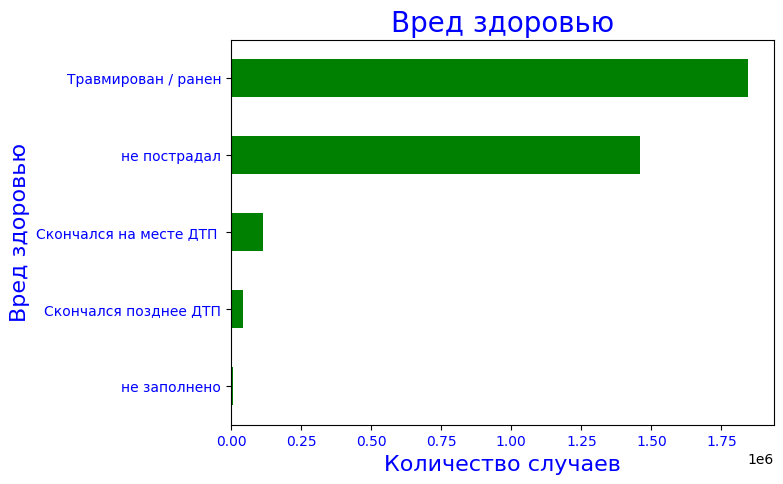

In [ ]:
# построим столбчатую диаграмму, чтобы определить значимые количества тех или иных значений
categ_disp(data_foot_part, 'health_status', 'Вред здоровью')

В столбце years_of_driving_experience введем категории по диапазону лет.
Распределим на:
- до 5 лет включительно
- от 5 до 10 лет включительно
- от 10 до 20 лет включительно
- от 20 до 30 лет включительно
- от 30 лет и более

In [ ]:
for i in tqdm(data_foot_part.query('years_of_driving_experience != "Не заполнено"')\
 ['years_of_driving_experience'].unique()):
  #if i != "Не заполнено":
  try:
    if i > 0:
      if i <= 5:
          data_foot_part.loc[(data_foot_part['years_of_driving_experience']) == i,
                            'years_of_driving_range'] = 'до 5 лет'
      elif i <= 10:
          data_foot_part.loc[(data_foot_part['years_of_driving_experience']) == i,
                            'years_of_driving_range'] = 'от 5 до 10 лет'
      elif i <= 20:
          data_foot_part.loc[(data_foot_part['years_of_driving_experience']) == i,
                            'years_of_driving_range'] = 'от 10 до 20 лет'
      elif i <= 30:
          data_foot_part.loc[(data_foot_part['years_of_driving_experience']) == i,
                            'years_of_driving_range'] = 'от 20 до 30 лет'
      elif i > 30:
          data_foot_part.loc[(data_foot_part['years_of_driving_experience']) == i,
                            'years_of_driving_range'] = 'от 30 лет и более'
  except:
        data_foot_part['years_of_driving_range'] = 'Не заполнено'



100%|██████████| 73/73 [00:22<00:00,  3.27it/s]


In [ ]:
# заполним пропущенные значения
data_foot_part.years_of_driving_range = data_foot_part.years_of_driving_range.fillna('Не заполнено')

In [ ]:
# удалим ненужный столбец
data_foot_part = data_foot_part.drop(columns='years_of_driving_experience')

In [ ]:
# изменим тип данных в столбце years_of_driving_range на category
ch_type(data_foot_part, 'years_of_driving_range', 'category')

In [ ]:
data_foot_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3466960 entries, 0 to 3466959
Data columns (total 5 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   id                      int32   
 1   role                    category
 2   gender                  category
 3   health_status           category
 4   years_of_driving_range  category
dtypes: category(4), int32(1)
memory usage: 26.5 MB


Сохраним датафрейм на диск в формате .csv.   
После чего обратимся к DataLens  и построим дашборд со следующими чартами для людей участников ДТП:
- категория участника ДТП
- пол участника ДТП
- ущерб здоровью
- водительский стаж

 Соединим с файлом data_foot_part и рассмотрим указанные выше категории в разрезе
 - количества ДТП
 - участников ДТП
 - раненых и травмированных
 - погибших
 - доля погибщих к количеству участников ДТП
 - доля пострадавших к количеству участников ДТП



  Соединим с файлом data_base и рассмотрим указанные выше категории в разрезе
 - категории освещенности
 - погоды
 - категории ДТП - столкновение, наезд


Установим фильтры:
- категория участника ДТП
- пол участника ДТП
- ущерб здоровью
- водительский стаж



In [ ]:
# Поскольку выгружаемый файл csv займет на ддиске более 200 МВ, нам придется разделить его на две части и вырузить по частям
# Выведем столбцы
data_foot_part.columns

Index(['id', 'role', 'gender', 'health_status', 'years_of_driving_range'], dtype='object')

In [ ]:
# Сохраним данные на диск в формате .csv
#data_foot_part.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_foot_part.csv', sep=',')

In [ ]:
# Разделим  data_foot_part на две части
data_foot_part_part_1 = data_foot_part[data_foot_part.columns[:3]]
data_foot_part_part_2 = data_foot_part[['id'] + data_foot_part.columns[3:4].tolist() ]
data_foot_part_part_3 = data_foot_part[['id'] + data_foot_part.columns[4:].tolist() ]
print(f'data_foot_part_part_1\n {data_foot_part_part_1.head(2)} \n\n \
data_foot_part_part_2 \n{data_foot_part_part_2.head(2)}')


data_foot_part_part_1
         id      role   gender
0  2525237  Водитель  Мужской
1  2060303  Пассажир  Женский 

 data_foot_part_part_2 
        id health_status
0  2525237  не пострадал
1  2060303  не пострадал


In [ ]:
# Сохраним все части на диск в формате .csv
data_foot_part_part_1.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_foot_part_part_1.csv', sep=',')
data_foot_part_part_2.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_foot_part_part_2.csv', sep=',')
data_foot_part_part_3.to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_foot_part_part_3.csv', sep=',')


In [ ]:
# Для проверки предположения сохраним часть датасета с данными о тяжести вреда здоровью
#data_foot_part[['id', 'health_status']].to_csv(r'/content/drive/MyDrive/Мастерская_Аналитика_ДТП/data_foot_part_part_1.csv', sep=',')

In [ ]:
del data_foot_part

# [Ссылка на дашборд](https://datalens.yandex/s1rbmtass104g)